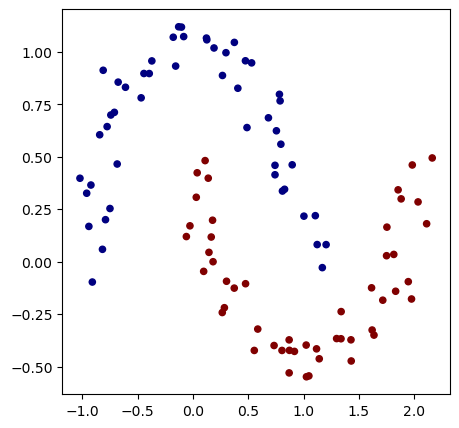

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
import random
from shrimpgrad import Tensor, nn, dtypes

np.random.seed(1337)
random.seed(1337)

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)
X = X.astype(float)
y = y.astype(float)
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [2]:
X_train = Tensor.fromlist(X.shape, X.flatten().tolist())
y_train = Tensor.fromlist((100,1), y.flatten().tolist())
class ShallowNet:
    def __init__(self):
        self.layers: List[Callable[[Tensor], Tensor]] = [
         nn.Linear(2, 50), Tensor.relu,
         nn.Linear(50, 1), Tensor.sigmoid,
        ]
    def __call__(self, x: Tensor):
        return x.sequential(self.layers)

In [3]:
snet = ShallowNet()
sgd = nn.optim.SGD(nn.get_parameters(snet), lr=3.0)

from shrimpgrad.engine.jit import ShrimpJit

def optimize(model, opt, X, y, epochs=50, lr=0.01):
    target = (y > 0).realize().data()
    @ShrimpJit
    def train(X,y):
        opt.zero_grad()
        out = model(X)
        loss = out.binary_cross_entropy(y)
        loss.backward()
        opt.step()
        return out, loss
    for epoch in range(epochs):
        out, loss = train(X,y)
        numerator = (target == (out.data() > 0.5)).sum()
        accuracy = (numerator / out.size(0)) * 100.0
        print(f'epoch={epoch} loss={loss.data()} acc={accuracy}')

optimize(snet, sgd, X_train, y_train)

[JIT_IGNORE]
POST STEP REALIZE
POST STEP REALIZE
POST STEP REALIZE
POST STEP REALIZE
epoch=0 loss=0.6840305328369141 acc=50.0
[JIT_CAPTURE]
POST STEP REALIZE
POST STEP REALIZE
POST STEP REALIZE
POST STEP REALIZE
[JIT_CAPTURE_KERNELS] capturing 41 kernels for CLANG with 2 changing inputs
#include<stdio.h>
#include<math.h>
void f_123782984908176(float* out0,float* data0,float* data1) {
  *out0 = (*data0)/(*data1);
}
void f_123782984909200(float* out1,float* data2,float* data3,float* out2) {
  int idx0 = 0;
  for (; idx0 < 100; idx0++) { 
    int idx1 = 0;
    for (; idx1 < 50; idx1++) { 
      int idx2 = 0;
      for (; idx2 < 2; idx2++) { 
        out1[idx0*100+idx1*2+idx2*1] = data2[idx0*2+idx1*0+idx2*1]*data3[idx0*0+idx1*2+idx2*1];
      }
    }
  }
  int idx3 = 0;
  int idx4 = 0;
  for (; idx4 < 100; idx4++) { 
    int idx5 = idx4*100;
    int idx6 = 0;
    for (; idx6 < 50; idx6++) { 
      int idx7 = idx6*2;
      int idx8 = 0;
      for (; idx8 < 2; idx8++) { 
        int idx9 = i

In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
input_ = Tensor.fromlist(Xmesh.shape, data=Xmesh.flatten().tolist())
scores = snet(input_)
scores.realize()
Z = np.array([s > 0.5 for s in scores.data()])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
